# Exercise 4

In [ ]:
import numpy as np
import heapq
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

def simulate_blocking(
    N_customers: int,
    m_servers: int,
    arrival_sampler,       # fn(rng, size) → array of interarrival times
    service_sampler,       # fn(rng) → one service time
    seed: int = None
) -> float:
    """
    Simulate a blocking system with m_servers and no queue.
    Returns fraction of customers blocked.
    """
    rng = np.random.default_rng(seed)
    # generate all arrival times
    inter = arrival_sampler(rng, size=N_customers)
    arrivals = np.cumsum(inter)
    
    busy_pq = []    # min‐heap of departure times
    blocked = 0
    
    for t in arrivals:
        # free up any servers that have finished by time t
        while busy_pq and busy_pq[0] <= t:
            heapq.heappop(busy_pq)
        if len(busy_pq) < m_servers:
            # accept customer
            s = service_sampler(rng)
            heapq.heappush(busy_pq, t + s)
        else:
            # blocked
            blocked += 1
    
    return blocked / N_customers

## 1

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# 1. Poisson arrivals (mean inter‐arrival 1), exponential service (mean 8)
#──────────────────────────────────────────────────────────────────────────────
def exp_arrivals(rng, size, rate=1.0):
    return rng.exponential(1/rate, size=size)

def exp_service(rng, mean=8.0):
    return rng.exponential(mean)

def part1_poisson_exp():
    reps = 10
    fracs = []
    for i in range(reps):
        f = simulate_blocking(
            N_customers=10_000,
            m_servers=10,
            arrival_sampler=lambda rng, size: exp_arrivals(rng, size, rate=1.0),
            service_sampler=lambda rng: exp_service(rng, mean=8.0),
            seed=12345 + i
        )
        fracs.append(f)
    fracs = np.array(fracs)
    mean_blk = fracs.mean()
    ci = stats.t.interval(
        0.95,
        df=reps-1,
        loc=mean_blk,
        scale=fracs.std(ddof=1)/np.sqrt(reps)
    )
    print("Part 1 (M/M/10/0):")
    print(f"  Mean blocked fraction = {mean_blk:.4f}")
    print(f"  95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    return fracs

## 2a & 2b

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# 2. Renewal arrivals
#    (a) Erlang‐k interarrivals with mean=1
#    (b) Hyperexp(p1,λ1; p2,λ2) mean=1
#──────────────────────────────────────────────────────────────────────────────
def erlang_arrivals(rng, size, k=2, mean=1.0):
    # gamma(shape=k, scale=mean/k)
    return rng.gamma(shape=k, scale=mean/k, size=size)

def hyperexp_arrivals(rng, size, p1=0.8, λ1=0.8333, p2=0.2, λ2=5.0):
    u = rng.random(size)
    out = np.empty(size)
    i1 = u < p1
    out[i1]  = rng.exponential(1/λ1, size=i1.sum())
    out[~i1] = rng.exponential(1/λ2, size=(~i1).sum())
    return out

def part2_renewal():
    reps = 10
    results = {}
    # 2(a) Erlang‐2 arrivals
    fracs_e = []
    for i in range(reps):
        fracs_e.append(simulate_blocking(
            10_000, 10,
            arrival_sampler=lambda rng, size: erlang_arrivals(rng, size, k=2),
            service_sampler=lambda rng: exp_service(rng, mean=8.0),
            seed=23456 + i
        ))
    results['Erlang‐2'] = np.array(fracs_e)
    
    # 2(b) Hyperexponential arrivals
    fracs_h = []
    for i in range(reps):
        fracs_h.append(simulate_blocking(
            10_000, 10,
            arrival_sampler=lambda rng, size: hyperexp_arrivals(rng, size),
            service_sampler=lambda rng: exp_service(rng, mean=8.0),
            seed=34567 + i
        ))
    results['Hyperexp'] = np.array(fracs_h)
    
    # Print CIs
    for name, arr in results.items():
        m = arr.mean()
        ci = stats.t.interval(
            0.95, len(arr)-1, loc=m,
            scale=arr.std(ddof=1)/np.sqrt(len(arr))
        )
        print(f"Part 2 ({name} arrivals): mean={m:.4f}, 95% CI=[{ci[0]:.4f}, {ci[1]:.4f}]")
    return results

## 3a,b,c

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# 3. Poisson arrivals + other service distributions
#    (a) constant=8
#    (b) Pareto k=1.05,2.05 (scale set so mean=8)
#    (c) uniform[0,16] as an extra
#──────────────────────────────────────────────────────────────────────────────
def constant_service(rng, mean=8.0):
    return mean

def pareto_service_factory(alpha, mean=8.0):
    # numpy pareto(a) gives X with PDF a x^{-a-1}, x>1.
    # so actual service = xm*(1+X) with xm = mean*(alpha-1)/alpha
    xm = mean*(alpha-1)/alpha
    def sampler(rng):
        return xm*(1 + rng.pareto(alpha))
    return sampler

def uniform_service(rng, low=0.0, high=16.0):
    return rng.uniform(low, high)

def part3_varied_service():
    reps = 10
    services = {
        'Constant': lambda rng: constant_service(rng, 8.0),
        'Pareto k=1.05': pareto_service_factory(1.05, mean=8.0),
        'Pareto k=2.05': pareto_service_factory(2.05, mean=8.0),
        'Uniform[0,16]': lambda rng: uniform_service(rng, 0,16)
    }
    results = {}
    for name, serv_fn in services.items():
        fracs = []
        for i in range(reps):
            fracs.append(simulate_blocking(
                10_000, 10,
                arrival_sampler=lambda rng, size: exp_arrivals(rng, size, rate=1.0),
                service_sampler=serv_fn,
                seed=45678 + i
            ))
        arr = np.array(fracs)
        m = arr.mean()
        ci = stats.t.interval(
            0.95, reps-1, loc=m, scale=arr.std(ddof=1)/np.sqrt(reps)
        )
        print(f"Part 3 ({name} service): mean={m:.4f}, 95% CI=[{ci[0]:.4f}, {ci[1]:.4f}]")
        results[name] = arr
    return results

## 4

Part 1 (M/M/10/0):
  Mean blocked fraction = 0.1199
  95% CI = [0.1160, 0.1237]
Part 2 (Erlang‐2 arrivals): mean=0.0942, 95% CI=[0.0901, 0.0983]
Part 2 (Hyperexp arrivals): mean=0.1398, 95% CI=[0.1332, 0.1464]
Part 3 (Constant service): mean=0.1223, 95% CI=[0.1201, 0.1245]
Part 3 (Pareto k=1.05 service): mean=0.0010, 95% CI=[0.0002, 0.0019]
Part 3 (Pareto k=2.05 service): mean=0.1220, 95% CI=[0.1161, 0.1280]
Part 3 (Uniform[0,16] service): mean=0.1235, 95% CI=[0.1212, 0.1257]
                Scenario  Mean Blocked Frac  CI Lower  CI Upper
0               M/M/10/0            0.11987  0.116035  0.123705
1      Erlang‐2 arrivals            0.09421  0.090101  0.098319
2      Hyperexp arrivals            0.13982  0.133237  0.146403
3       Constant service            0.12230  0.120146  0.124454
4  Pareto k=1.05 service            0.00101  0.000169  0.001851
5  Pareto k=2.05 service            0.12203  0.116067  0.127993
6  Uniform[0,16] service            0.12346  0.121205  0.125715


/var/folders/tj/czw2xwdj6jv1gvfb9pcj33sh0000gn/T/ipykernel_57538/2796263238.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df["Scenario"], rotation=45, ha='right')


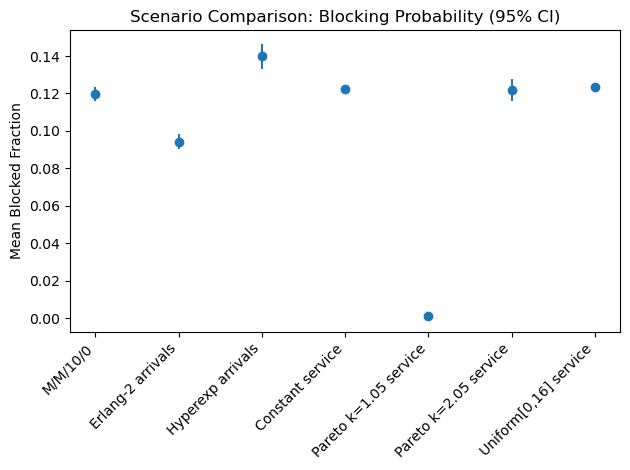

In [ ]:
# 4. Gather results from Parts 1–3 and compare in a table / plot

# Run Parts 1–3 to get the blocking–fraction arrays
fracs1   = part1_poisson_exp()     # returns np.array of 10 replications
results2 = part2_renewal()         # returns dict {'Erlang‐2': array, 'Hyperexp': array}
results3 = part3_varied_service()  # returns dict of service‐scenario → array

# Assemble summary data
data = []

# Part 1 summary
mean1 = fracs1.mean()
ci1   = stats.t.interval(
    0.95, len(fracs1)-1, loc=mean1,
    scale=fracs1.std(ddof=1)/np.sqrt(len(fracs1))
)
data.append(["M/M/10/0", mean1, ci1[0], ci1[1]])

# Part 2 summaries
for name, arr in results2.items():
    m, ci = arr.mean(), stats.t.interval(
        0.95, len(arr)-1, loc=arr.mean(),
        scale=arr.std(ddof=1)/np.sqrt(len(arr))
    )
    data.append([f"{name} arrivals", m, ci[0], ci[1]])

# Part 3 summaries
for name, arr in results3.items():
    m, ci = arr.mean(), stats.t.interval(
        0.95, len(arr)-1, loc=arr.mean(),
        scale=arr.std(ddof=1)/np.sqrt(len(arr))
    )
    data.append([f"{name} service", m, ci[0], ci[1]])

# Create DataFrame
df = pd.DataFrame(data, columns=["Scenario", "Mean Blocked Frac", "CI Lower", "CI Upper"])
print(df)

# Optional: plot with error bars
fig, ax = plt.subplots()
ax.errorbar(
    df["Scenario"],
    df["Mean Blocked Frac"],
    yerr=[df["Mean Blocked Frac"] - df["CI Lower"],
          df["CI Upper"] - df["Mean Blocked Frac"]],
    fmt="o"
)
ax.set_xticklabels(df["Scenario"], rotation=45, ha='right')
ax.set_ylabel("Mean Blocked Fraction")
ax.set_title("Scenario Comparison: Blocking Probability (95% CI)")
plt.tight_layout()
plt.show()

In [ ]:
if __name__ == "__main__":
    # Run each part in sequence
    part1_poisson_exp()
    part2_renewal()
    part3_varied_service()

Part 1 (M/M/10/0):
  Mean blocked fraction = 0.1199
  95% CI = [0.1160, 0.1237]
Part 2 (Erlang‐2 arrivals): mean=0.0942, 95% CI=[0.0901, 0.0983]
Part 2 (Hyperexp arrivals): mean=0.1398, 95% CI=[0.1332, 0.1464]
Part 3 (Constant service): mean=0.1223, 95% CI=[0.1201, 0.1245]
Part 3 (Pareto k=1.05 service): mean=0.0010, 95% CI=[0.0002, 0.0019]
Part 3 (Pareto k=2.05 service): mean=0.1220, 95% CI=[0.1161, 0.1280]
Part 3 (Uniform[0,16] service): mean=0.1235, 95% CI=[0.1212, 0.1257]
